In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import cv2
import os

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

DATASET_PATH = "dataset"
TRAIN_FILE = os.path.join(DATASET_PATH, "emnist-byclass-train.csv")
TEST_FILE = os.path.join(DATASET_PATH, "emnist-byclass-test.csv")
MAPPING_FILE = os.path.join(DATASET_PATH, "emnist-byclass-mapping.txt")

In [19]:
def load_emnist_byclass():
    # Загружаем тренировочные и тестовые данные
    train_data = pd.read_csv(TRAIN_FILE)
    test_data = pd.read_csv(TEST_FILE)
    
    # Маппинг классов (номера к символам)
    # Формат: номер_класса ASCII_код
    mapping = pd.read_csv(MAPPING_FILE, 
                          sep=' ', 
                          header=None, 
                          names=['class', 'ascii'])
    
    print(f"Тренировочные данные: {train_data.shape}")
    print(f"Тестовые данные: {test_data.shape}")
    print(f"Количество классов: {len(mapping)}")
    print(f"Пример маппинга:\n{mapping.head(10)}")
    
    return train_data, test_data, mapping

# Загрузка данных
train_data, test_data, mapping = load_emnist_byclass()

Тренировочные данные: (697931, 785)
Тестовые данные: (116322, 785)
Количество классов: 62
Пример маппинга:
   class  ascii
0      0     48
1      1     49
2      2     50
3      3     51
4      4     52
5      5     53
6      6     54
7      7     55
8      8     56
9      9     57


In [ ]:
def prepare_emnist_data(train_data, test_data):
    X_train = train_data.iloc[:, 1:].values
    y_train = train_data.iloc[:, 0].values
    X_test = test_data.iloc[:, 1:].values
    y_test = test_data.iloc[:, 0].values
    print(f"   X_train shape: {X_train.shape}")
    print(f"   y_train shape: {y_train.shape}")

    X_train = X_train.reshape(-1, 28, 28, 1)  #(все строки, 28 на 28, 1 канал)
    X_test = X_test.reshape(-1, 28, 28, 1)

    X_train = np.transpose(X_train, (0, 2, 1, 3))
    X_test = np.transpose(X_test, (0, 2, 1, 3))

    X_train = X_train.astype('float32') / 255.0
    X_test = X_test.astype('float32') / 255.0
    
    num_classes = 62
    y_train_cat = keras.utils.to_categorical(y_train, num_classes)
    y_test_cat = keras.utils.to_categorical(y_test, num_classes)
    
    print(f"   После преобразования:")
    print(f"   X_train shape: {X_train.shape}")
    print(f"   y_train_cat shape: {y_train_cat.shape}")
    
    return X_train, X_test, y_train_cat, y_test_cat, y_train, y_test

X_train, X_test, y_train_cat, y_test_cat, y_train, y_test = prepare_emnist_data(train_data, test_data)

   X_train shape: (697931, 784)
   y_train shape: (697931,)
   После преобразования:
   X_train shape: (697931, 28, 28, 1)
   y_train_cat shape: (697931, 62)


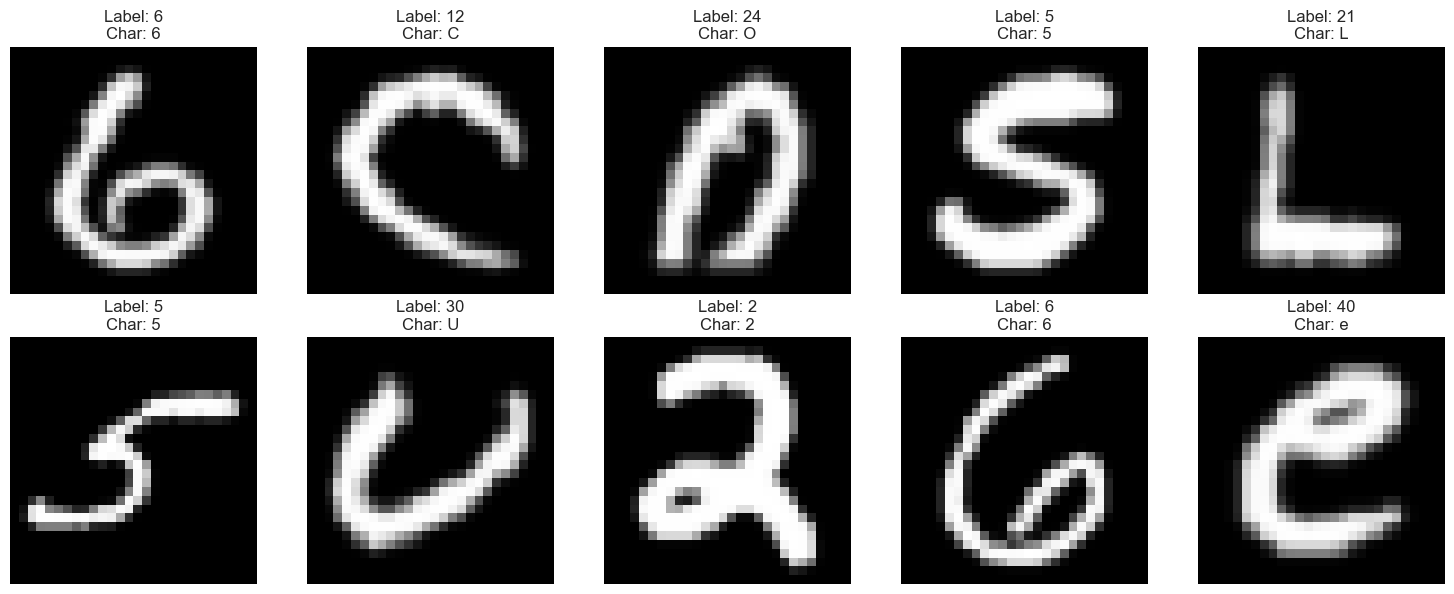

In [29]:
def show_samples(X, y, mapping):
    
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.ravel()
    
    for i in range(10):
        idx = np.random.randint(0, len(X))
        
        axes[i].imshow(X[idx].reshape(28, 28), cmap='gray')
        
        label = y[idx]
        ascii_code = mapping.loc[mapping['class'] == label, 'ascii'].values[0]
        char = chr(ascii_code)
        
        axes[i].set_title(f'Label: {label}\nChar: {char}')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

show_samples(X_train, y_train, mapping)

In [34]:
def create_cnn_model(input_shape=(28, 28, 1), num_classes=62):
    model = keras.Sequential([
        layers.Conv2D(16, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2, 2)),
        
        # Второй сверточный слой
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        # Всего один полносвязный слой
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(62, activation='softmax')
    ])
    
    return model

# Создаем модель
model = create_cnn_model()
model.summary()

c:\ulstu\4\СИИ\model\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 26, 26, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 13, 13, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 11, 11, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 5, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 62)             │         4,030 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,094 (234.74 KB)

 Trainable params: 60,094 (234.74 KB)

 Non-trainable params: 0 (0.00 B)

In [35]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [36]:
from sklearn.model_selection import train_test_split

# Разделяем тренировочные данные на train/validation
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train_cat, 
    test_size=0.2, 
    random_state=42,
    stratify=y_train  # сохраняем пропорции классов
)

print(f"Размеры:")
print(f"  X_train_split: {X_train_split.shape}")
print(f"  X_val: {X_val.shape}")

history = model.fit(
    X_train_split, y_train_split,
    validation_data=(X_val, y_val),
    epochs=30,  # можно начать с 30 эпох
    batch_size=64,
    verbose=1
)

Размеры:
  X_train_split: (558344, 28, 28, 1)
  X_val: (139587, 28, 28, 1)
Epoch 1/30
8725/8725 ━━━━━━━━━━━━━━━━━━━━ 94s 10ms/step - accuracy: 0.7555 - loss: 0.7841 - val_accuracy: 0.8363 - val_loss: 0.4704
Epoch 2/30
8725/8725 ━━━━━━━━━━━━━━━━━━━━ 82s 9ms/step - accuracy: 0.8143 - loss: 0.5547 - val_accuracy: 0.8475 - val_loss: 0.4350
Epoch 3/30
8725/8725 ━━━━━━━━━━━━━━━━━━━━ 93s 11ms/step - accuracy: 0.8256 - loss: 0.5148 - val_accuracy: 0.8505 - val_loss: 0.4207
Epoch 4/30
8725/8725 ━━━━━━━━━━━━━━━━━━━━ 98s 11ms/step - accuracy: 0.8314 - loss: 0.4934 - val_accuracy: 0.8544 - val_loss: 0.4097
Epoch 5/30
8725/8725 ━━━━━━━━━━━━━━━━━━━━ 130s 10ms/step - accuracy: 0.8349 - loss: 0.4790 - val_accuracy: 0.8554 - val_loss: 0.4068
Epoch 6/30
8725/8725 ━━━━━━━━━━━━━━━━━━━━ 82s 9ms/step - accuracy: 0.8376 - loss: 0.4695 - val_accuracy: 0.8560 - val_loss: 0.4035
Epoch 7/30
8725/8725 ━━━━━━━━━━━━━━━━━━━━ 86s 10ms/step - accuracy: 0.8398 - loss: 0.4615 - val_accuracy: 0.8558 - val_loss: 0.4037
Ep

C:\Users\pasha\AppData\Local\Temp\ipykernel_31800\1964309139.py:36: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\pasha\AppData\Local\Temp\ipykernel_31800\1964309139.py:36: UserWarning: Glyph 10007 (\N{BALLOT X}) missing from font(s) Arial.
  plt.tight_layout()


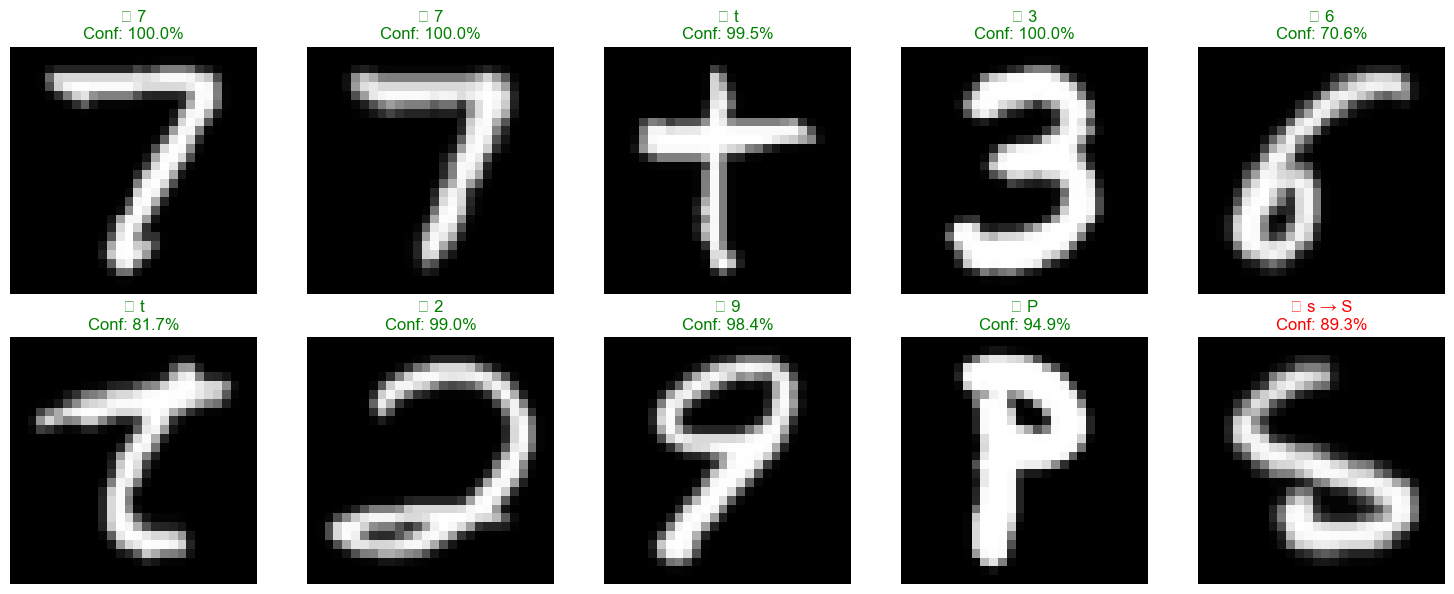

Правильно распознано: 9/10 (90.0%)


In [38]:
def test_random_predictions(model, X_test, y_test, mapping, n=10):
    
    # Выбираем случайные индексы
    indices = np.random.choice(len(X_test), n, replace=False)
    
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.ravel()
    
    correct = 0
    predictions = []
    
    for i, idx in enumerate(indices):
        img = X_test[idx]
        true_label = y_test[idx]
        
        # Предсказание
        pred_proba = model.predict(img[np.newaxis, ...], verbose=0)
        pred_label = np.argmax(pred_proba)
        
        # Получаем символы
        true_char = chr(mapping.loc[mapping['class'] == true_label, 'ascii'].values[0])
        pred_char = chr(mapping.loc[mapping['class'] == pred_label, 'ascii'].values[0])
        
        # Отображаем
        axes[i].imshow(img.reshape(28, 28), cmap='gray')
        
        if true_label == pred_label:
            axes[i].set_title(f'✓ {true_char}\nConf: {pred_proba[0][pred_label]:.1%}', color='green')
            correct += 1
        else:
            axes[i].set_title(f'✗ {true_char} → {pred_char}\nConf: {pred_proba[0][pred_label]:.1%}', color='red')
        
        axes[i].axis('off')
        predictions.append((true_char, pred_char, pred_proba[0][pred_label]))
    
    plt.tight_layout()
    plt.show()
    
    print(f"Правильно распознано: {correct}/{n} ({correct/n:.1%})")
    return predictions

# Тестируем
predictions = test_random_predictions(model, X_test, y_test, mapping, 10)

In [40]:
# Сохранение модели в формате .keras
model.save('models/CNN_model_86%_acc.keras')

# Сохранение маппинга для использования в приложении
mapping.to_csv('models/emnist_mapping.csv', index=False)
print("Маппинг сохранен как 'emnist_mapping.csv'")

Маппинг сохранен как 'emnist_mapping.csv'


Модель загружена: models/CNN_model_improver.keras
Входной размер: (None, 28, 28, 1)
Выходных классов: 62
Найден маппинг CSV: models/emnist_mapping.csv
Маппинг загружен. Классов: 62
['tests\\others\\test6.jpg', 'tests\\others\\test7.jpg']
Найдено изображений: 2

ИЗОБРАЖЕНИЕ 1/2: test6.jpg

ОБРАБОТКА ИЗОБРАЖЕНИЯ: tests\others\test6.jpg
Минимальное значение: 0
Максимальное значение: 255
Среднее значение: 3.81
Количество ненулевых пикселей: 33011
✅ Количество строк: 3

✅ Выделено символов до объединения: 31
[DEBUG] Начинаем объединение...
[DEBUG] Все bounding boxes после сортировки:
  0: line=0, (x=271, y=134, w=77, h=174)
  1: line=0, (x=432, y=134, w=63, h=174)
  2: line=0, (x=523, y=134, w=67, h=174)
  3: line=0, (x=621, y=134, w=72, h=174)
  4: line=0, (x=835, y=134, w=85, h=174)
  5: line=0, (x=926, y=134, w=63, h=174)
  6: line=0, (x=1109, y=134, w=43, h=174)
  7: line=0, (x=1178, y=134, w=47, h=174)
  8: line=0, (x=1256, y=134, w=73, h=174)
  9: line=0, (x=1338, y=134, w=24, h=174)


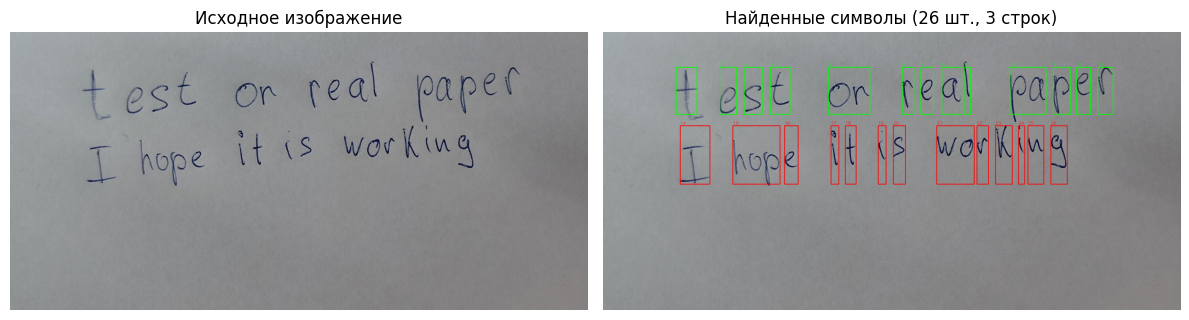


Распознавание 26 символов...
  Символ 1 (строка 1): 't' (уверенность: 72.4%)
  Символ 2 (строка 1): 'C' (уверенность: 22.9%)
  Символ 3 (строка 1): 'S' (уверенность: 88.0%)
  Символ 4 (строка 1): 't' (уверенность: 72.6%)
  Символ 5 (строка 1): '0' (уверенность: 70.4%)
  Символ 6 (строка 1): 'I' (уверенность: 28.5%)
  Символ 7 (строка 1): 'e' (уверенность: 95.1%)
  Символ 8 (строка 1): 'a' (уверенность: 81.8%)
  Символ 9 (строка 1): 'l' (уверенность: 39.4%)
  Символ 10 (строка 1): 'a' (уверенность: 63.2%)
  Символ 11 (строка 1): 'r' (уверенность: 33.3%)
  Символ 12 (строка 1): 'e' (уверенность: 98.0%)
  Символ 13 (строка 1): 'r' (уверенность: 31.5%)
  Символ 14 (строка 3): 'I' (уверенность: 37.4%)
  Символ 15 (строка 3): 'P' (уверенность: 50.5%)
  Символ 16 (строка 3): 'e' (уверенность: 96.6%)
  Символ 17 (строка 3): 'l' (уверенность: 45.4%)
  Символ 18 (строка 3): 't' (уверенность: 65.0%)
  Символ 19 (строка 3): 'l' (уверенность: 50.0%)
  Символ 20 (строка 3): 'S' (уверенность: 81.2%)

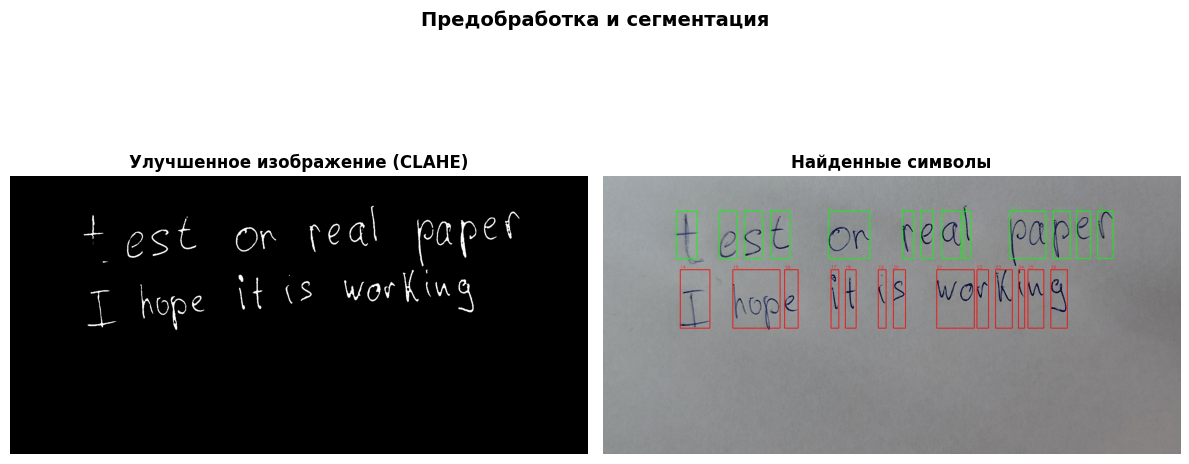

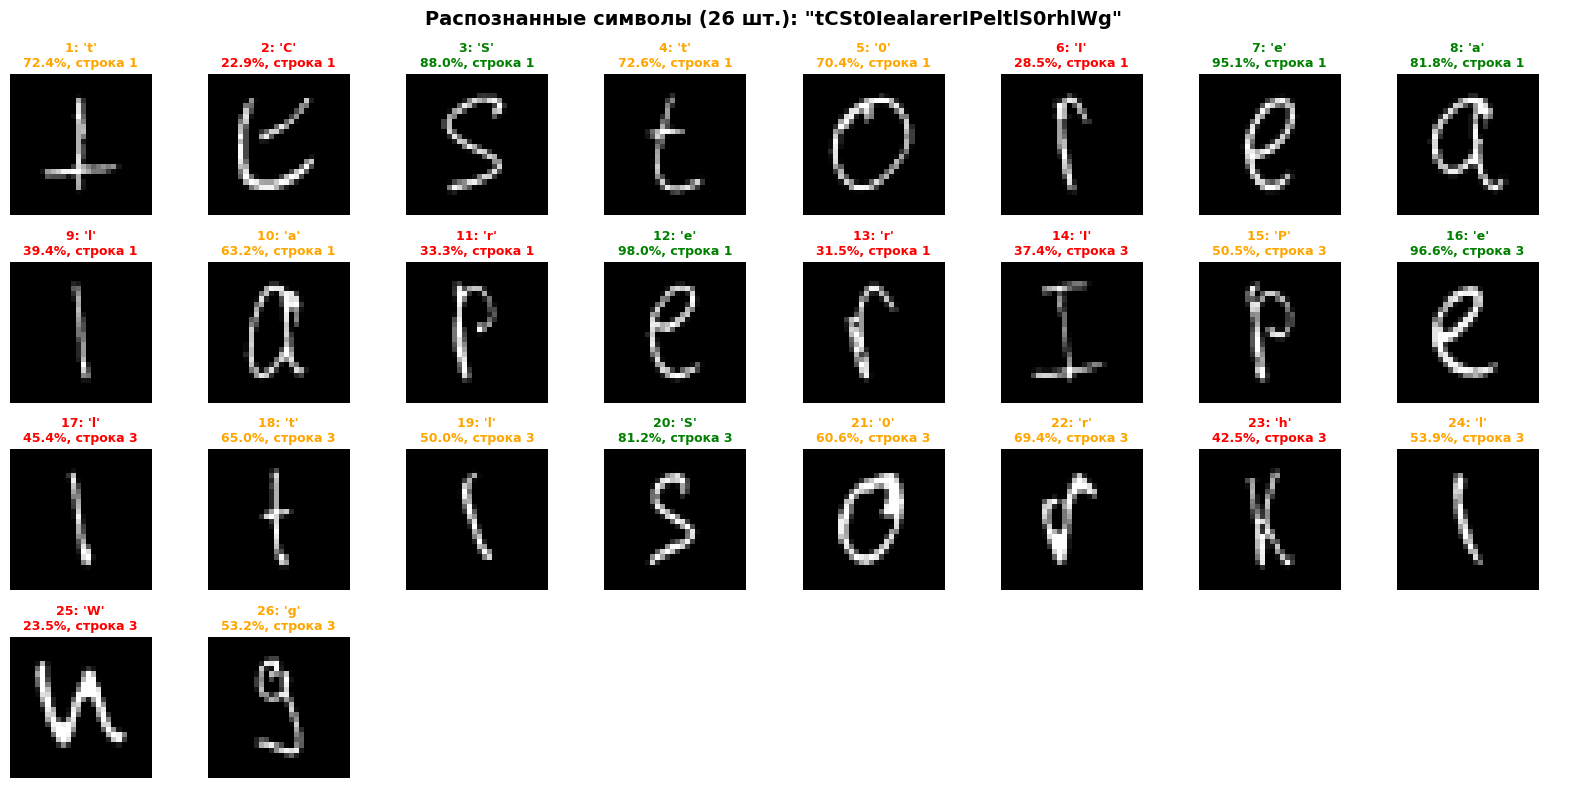


СВОДНАЯ ИНФОРМАЦИЯ:
Всего символов: 26
Количество строк: 2

Текст по строкам:
----------------------------------------
Строка 1: tCSt0 Ieala rer
Строка 3: IPelt lS0rh lWg
----------------------------------------

Статистика уверенности:
  Средняя уверенность: 58.71%
  Высокая уверенность (>80%): 6 симв.
  Средняя уверенность (50-80%): 11 симв.
  Низкая уверенность (<50%): 9 симв.

РАСПОЗНАННЫЙ ТЕКСТ:
----------------------------------------
tCSt 0 Ieal arer
IPe ltlS 0rhlWg
----------------------------------------
Статистика: 26 символов, 2 строк, уверенность: 58.71%
ИЗОБРАЖЕНИЕ 2/2: test7.jpg

ОБРАБОТКА ИЗОБРАЖЕНИЯ: tests\others\test7.jpg
Минимальное значение: 0
Максимальное значение: 255
Среднее значение: 4.66
Количество ненулевых пикселей: 74980
✅ Количество строк: 10

✅ Выделено символов до объединения: 29
[DEBUG] Начинаем объединение...
[DEBUG] Все bounding boxes после сортировки:
  0: line=0, (x=2028, y=244, w=118, h=19)
  1: line=2, (x=450, y=284, w=91, h=249)
  2: line=2, (x=58

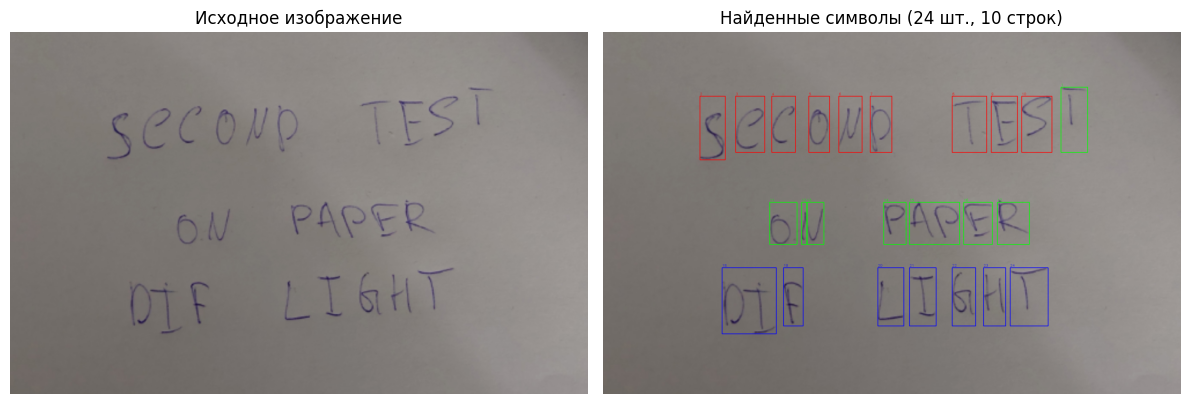


Распознавание 24 символов...
  Символ 1 (строка 1): 'l' (уверенность: 40.9%)
  Символ 2 (строка 3): 'S' (уверенность: 18.6%)
  Символ 3 (строка 3): 'C' (уверенность: 67.5%)
  Символ 4 (строка 3): 'C' (уверенность: 82.5%)
  Символ 5 (строка 3): '0' (уверенность: 59.4%)
  Символ 6 (строка 3): 'Y' (уверенность: 31.5%)
  Символ 7 (строка 3): 'D' (уверенность: 39.4%)
  Символ 8 (строка 3): 'l' (уверенность: 41.1%)
  Символ 9 (строка 3): 'E' (уверенность: 91.2%)
  Символ 10 (строка 3): '5' (уверенность: 42.9%)
  Символ 11 (строка 7): '0' (уверенность: 69.2%)
  Символ 12 (строка 7): 'l' (уверенность: 39.2%)
  Символ 13 (строка 7): 'J' (уверенность: 15.3%)
  Символ 14 (строка 7): 'P' (уверенность: 90.0%)
  Символ 15 (строка 7): 'P' (уверенность: 81.8%)
  Символ 16 (строка 7): 'E' (уверенность: 59.8%)
  Символ 17 (строка 7): 'R' (уверенность: 92.7%)
  Символ 18 (строка 8): '0' (уверенность: 41.7%)
  Символ 19 (строка 8): 't' (уверенность: 90.5%)
  Символ 20 (строка 8): 'L' (уверенность: 84.5%)

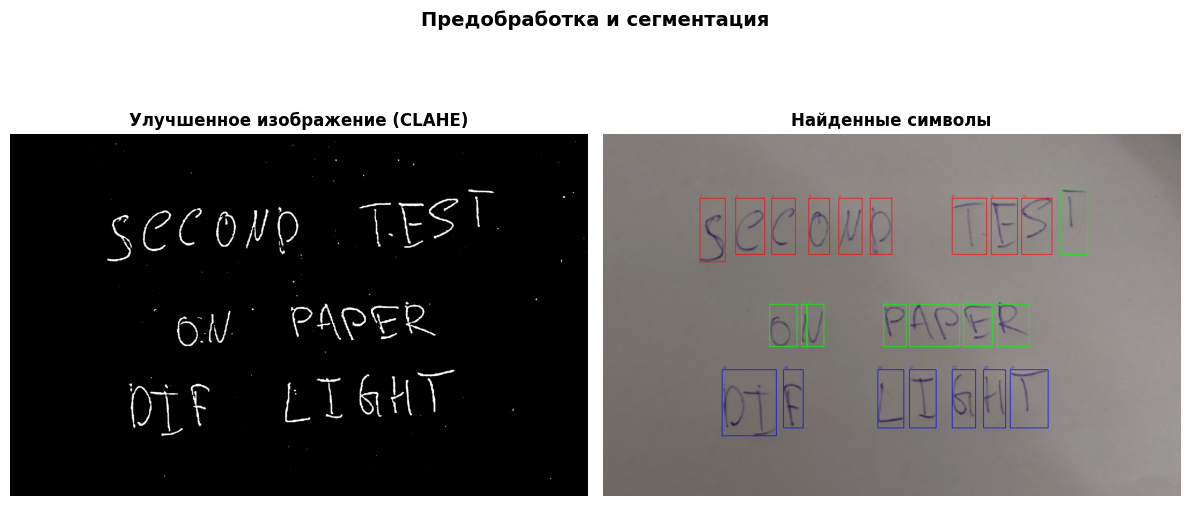

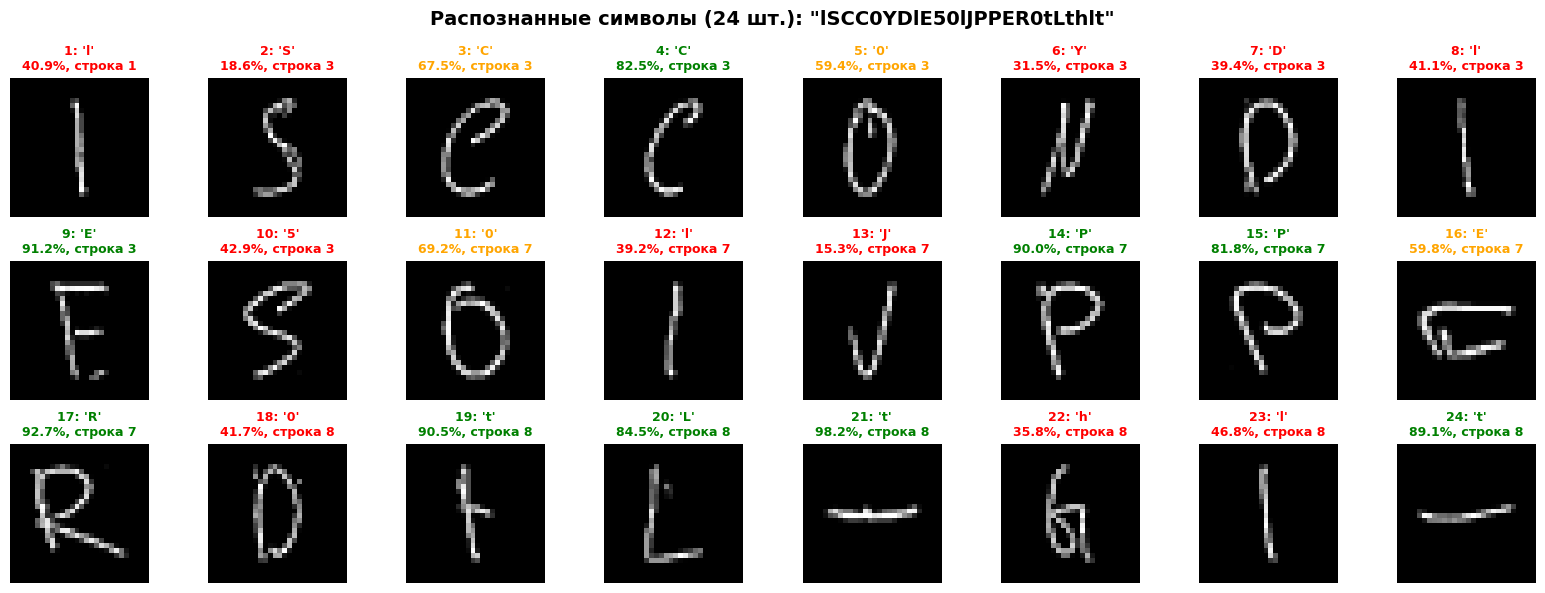


СВОДНАЯ ИНФОРМАЦИЯ:
Всего символов: 24
Количество строк: 4

Текст по строкам:
----------------------------------------
Строка 1: l
Строка 3: SCC0Y DlE5
Строка 7: 0lJPP ER
Строка 8: 0tLth lt
----------------------------------------

Статистика уверенности:
  Средняя уверенность: 60.40%
  Высокая уверенность (>80%): 9 симв.
  Средняя уверенность (50-80%): 4 симв.
  Низкая уверенность (<50%): 11 симв.

РАСПОЗНАННЫЙ ТЕКСТ:
----------------------------------------
l
SCC0YD lE5
0lJ PPER
0t Lthlt
----------------------------------------
Статистика: 24 символов, 4 строк, уверенность: 60.40%

Обработка завершена. Всего обработано: 2 изображений


In [90]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd
from tensorflow import keras
from collections import defaultdict

def advanced_noise_removal(image):
    """
    Упрощенная версия для рукописного текста — CLAHE + гамма-коррекция + морфология
    """
    # 1. Преобразуем в оттенки серого
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image.copy()
    
    # 2. Улучшаем контраст с помощью CLAHE
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(gray)
    
    # 3. Гамма-коррекция для усиления контраста
    # Гамма < 1 — усиливает тени (фон станет темнее), > 1 — усиливает света (текст станет ярче)
    gamma = 0.8  # попробуйте 0.7–0.9
    enhanced = np.array(255 * (enhanced / 255) ** gamma, dtype='uint8')
    
    # 4. Морфологическое удаление шума
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    denoised = cv2.morphologyEx(enhanced, cv2.MORPH_OPEN, kernel, iterations=2)
    
    return denoised
    
def prepare_handwritten_image_for_recognition(image):
    """
    Полная предобработка изображения для распознавания рукописного текста.
    Удаляет шумы и готовит изображение для модели.
    """
    # 1. Удаление шума
    denoised = advanced_noise_removal(image)
    
    # 2. Улучшение контраста
    _, otsu_thresh = cv2.threshold(denoised, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    # Затем адаптивная бинаризация поверх Otsu (если нужно)
    adaptive = cv2.adaptiveThreshold(
        denoised, 255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV,
        blockSize=31,
        C=7
    )
    binary = cv2.bitwise_and(otsu_thresh, adaptive)
    
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary, connectivity=8)
    min_area = 35  # Для мелкого почерка — 25, для крупного — 50
    cleaned = np.zeros_like(binary)
    for i in range(1, num_labels):  # Пропускаем фон (метка 0)
        if stats[i, cv2.CC_STAT_AREA] >= min_area:
            cleaned[labels == i] = 255
    
    # 4. Удаление оставшихся шумов
    cleaned = cv2.medianBlur(binary, 3)
    
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
    cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_CLOSE, kernel, iterations=1)
    
    print(f"Минимальное значение: {cleaned.min()}")
    print(f"Максимальное значение: {cleaned.max()}")
    print(f"Среднее значение: {cleaned.mean():.2f}")
    print(f"Количество ненулевых пикселей: {np.count_nonzero(cleaned)}")
    
    return cleaned

    
class TextRecognitionSystem:
    def __init__(self, model_path='models/CNN_model_86%_acc.keras', mapping_path='models/char_mapping.json'):
        
        # 1. Загружаем модель
        if not os.path.exists(model_path):
            print(f"Ошибка: Модель не найдена по пути: {model_path}")
            model_path_h5 = model_path.replace('.keras', '.h5')
            if os.path.exists(model_path_h5):
                print(f"Найдена модель .h5: {model_path_h5}")
                model_path = model_path_h5
            else:
                raise FileNotFoundError(f"Модель не найдена: {model_path}")
        
        self.model = keras.models.load_model(model_path)
        print(f"Модель загружена: {model_path}")
        print(f"Входной размер: {self.model.input_shape}")
        print(f"Выходных классов: {self.model.output_shape[1]}")
        
        # 2. Загружаем маппинг
        self.char_mapping = self.load_mapping(mapping_path)
        print(f"Маппинг загружен. Классов: {len(self.char_mapping)}")
        
        # 3. Параметры для определения пробелов и строк
        self.space_threshold_factor = 1.5  # Во сколько раз расстояние должно быть больше среднего для пробела
        self.line_threshold_factor = 1.2   # Во сколько раз расстояние по Y должно быть больше для новой строки
        self.supported_formats = ['.jpg', '.jpeg', '.png', '.bmp', '.JPG', '.JPEG', '.PNG', '.BMP']
    
    def merge_close_symbols(self, bounding_boxes, line_indices, img_shape):
        """
        Объединяет близко расположенные символы по горизонтали и вертикали.
        Возвращает новые bounding boxes и индексы строк.
        """
        print("[DEBUG] Начинаем объединение...")
        if not bounding_boxes:
            return [], []

        # Сначала сортируем по координате Y (сверху вниз), затем по X (слева направо)
        indexed_boxes = list(enumerate(bounding_boxes))
        indexed_boxes.sort(key=lambda item: (item[1][1], item[1][0]))  # sort by y, then x

        # Извлекаем отсортированные данные
        sorted_indices = [i for i, _ in indexed_boxes]
        sorted_boxes = [box for _, box in indexed_boxes]
        sorted_lines = [line_indices[i] for i in sorted_indices]

        print(f"[DEBUG] Все bounding boxes после сортировки:")
        for i, (x, y, w, h) in enumerate(sorted_boxes):
            print(f"  {i}: line={sorted_lines[i]}, (x={x}, y={y}, w={w}, h={h})")

        # Пороги для объединения
        HORIZONTAL_THRESHOLD = 8   # для букв в слове
        VERTICAL_THRESHOLD = 25     # для точек над буквами (уменьшил, т.к. нужно учитывать высоту)
        VERTICAL_HORIZONTAL_OVERLAP = 0.3  # минимальное перекрытие по горизонтали для вертикального объединения

        merged_boxes = []
        merged_line_indices = []
        used = [False] * len(sorted_boxes)

        for i in range(len(sorted_boxes)):
            if used[i]:
                continue

            x1, y1, w1, h1 = sorted_boxes[i]
            current_box = [x1, y1, w1, h1]
            current_line = sorted_lines[i]
            current_center_x = x1 + w1 / 2
            current_center_y = y1 + h1 / 2

            # Объединяем символы в слове (горизонтально)
            for j in range(i + 1, len(sorted_boxes)):
                if used[j] or sorted_lines[j] != current_line:
                    continue

                x2, y2, w2, h2 = sorted_boxes[j]
                
                # Проверяем горизонтальную близость
                distance_x = x2 - (x1 + w1)  # расстояние между правым краем первого и левым краем второго
                if 0 <= distance_x <= HORIZONTAL_THRESHOLD:
                    # Проверяем вертикальное выравнивание (символы должны быть примерно на одной высоте)
                    y_overlap = min(y1 + h1, y2 + h2) - max(y1, y2)
                    min_height = min(h1, h2)
                    
                    if y_overlap > min_height * 0.3:  # есть достаточное перекрытие по вертикали
                        print(f"[DEBUG] Горизонтальное объединение {i} и {j}: distX={distance_x:.1f}, y_overlap={y_overlap:.1f}")
                        # Объединяем прямоугольники
                        new_x = min(x1, x2)
                        new_y = min(y1, y2)
                        new_w = max(x1 + w1, x2 + w2) - new_x
                        new_h = max(y1 + h1, y2 + h2) - new_y
                        
                        current_box = [new_x, new_y, new_w, new_h]
                        x1, y1, w1, h1 = current_box
                        used[j] = True

            # Теперь ищем диакритические знаки (точки над/под буквами)
            # Они должны быть на другой строке, но близко по вертикали и примерно по центру
            for j in range(len(sorted_boxes)):
                if used[j] or i == j or sorted_lines[j] == current_line:
                    continue

                x2, y2, w2, h2 = sorted_boxes[j]
                
                # Проверяем вертикальное расстояние
                vertical_distance = min(
                    abs(y1 - (y2 + h2)),  # текущий выше кандидата
                    abs((y1 + h1) - y2)   # текущий ниже кандидата
                )
                
                if vertical_distance <= VERTICAL_THRESHOLD:
                    # Проверяем горизонтальное перекрытие
                    x_overlap = min(x1 + w1, x2 + w2) - max(x1, x2)
                    min_width = min(w1, w2)
                    
                    # Для точек/диакритических знаков достаточно небольшого перекрытия
                    if x_overlap > min_width * VERTICAL_HORIZONTAL_OVERLAP:
                        # Проверяем, что один символ значительно меньше другого (это скорее всего точка)
                        area1 = w1 * h1
                        area2 = w2 * h2
                        
                        if area2 < area1 * 0.5 or area1 < area2 * 0.5:
                            print(f"[DEBUG] Вертикальное объединение {i} и {j}: vertDist={vertical_distance:.1f}, x_overlap={x_overlap:.1f}")
                            # Объединяем прямоугольники
                            new_x = min(x1, x2)
                            new_y = min(y1, y2)
                            new_w = max(x1 + w1, x2 + w2) - new_x
                            new_h = max(y1 + h1, y2 + h2) - new_y
                            
                            current_box = [new_x, new_y, new_w, new_h]
                            x1, y1, w1, h1 = current_box
                            used[j] = True

            merged_boxes.append(tuple(current_box))
            merged_line_indices.append(current_line)
            used[i] = True

        print(f"[DEBUG] До объединения: {len(bounding_boxes)} символов")
        print(f"[DEBUG] После объединения: {len(merged_boxes)} символов")
        
        # Сортируем результат по строкам и позиции
        result = list(zip(merged_boxes, merged_line_indices))
        result.sort(key=lambda item: (item[1], item[0][0], item[0][1]))
        
        merged_boxes = [box for box, _ in result]
        merged_line_indices = [line for _, line in result]

        return merged_boxes, merged_line_indices
    
    def load_mapping(self, mapping_path):
        """Загрузка маппинга с обработкой разных форматов"""
        char_mapping = {}
        
        if not os.path.exists(mapping_path):
            mapping_path_csv = 'models/emnist_mapping.csv'
            if os.path.exists(mapping_path_csv):
                print(f"Найден маппинг CSV: {mapping_path_csv}")
                mapping_df = pd.read_csv(mapping_path_csv)
                for _, row in mapping_df.iterrows():
                    char_mapping[int(row['class'])] = chr(int(row['ascii']))
            else:
                raise FileNotFoundError(f"Маппинг не найден: {mapping_path}")
        else:
            if mapping_path.endswith('.csv'):
                mapping_df = pd.read_csv(mapping_path)
                for _, row in mapping_df.iterrows():
                    if 'class' in row and 'ascii' in row:
                        char_mapping[int(row['class'])] = chr(int(row['ascii']))
            elif mapping_path.endswith('.json'):
                with open(mapping_path, 'r', encoding='utf-8') as f:
                    char_mapping = json.load(f)
                    # Преобразуем строковые ключи в int при необходимости
                    char_mapping = {int(k) if k.isdigit() else k: v for k, v in char_mapping.items()}
        
        return char_mapping
    
    def validate_image(self, image_path):
        if not os.path.exists(image_path):
            raise FileNotFoundError(f"Файл не найден: {image_path}")
        
        file_ext = os.path.splitext(image_path)[1].lower()
        if file_ext not in self.supported_formats:
            raise ValueError(f"Неподдерживаемый формат: {file_ext}. "
                           f"Поддерживаемые: {', '.join(self.supported_formats)}")
        
        file_size_mb = os.path.getsize(image_path) / (1024 * 1024)
        if file_size_mb > 10:
            raise ValueError(f"Файл слишком большой: {file_size_mb:.1f} МБ. "
                           f"Максимум: 10 МБ")
        
        img = cv2.imread(image_path)
        if img is None:
            raise ValueError("Не удалось загрузить изображение. Возможно, файл поврежден.")
        
        return img
    
    def preprocess_for_emnist(self, image):
        """Приведение изображения символа к формату EMNIST"""
        # 1. Убедимся, что это одноканальное изображение
        if len(image.shape) == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # 2. Применяем пороговую обработку, белый текст на черном фоне
        if np.mean(image) > 127:
            thresh = 255 - image  # Инвертируем
        else:
            thresh = image  # Оставляем как есть
        
        # 3. Находим контуры символа
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        if contours:
            # Берем самый большой контур
            contour = max(contours, key=cv2.contourArea)
            x, y, w, h = cv2.boundingRect(contour)
            
            # Вырезаем символ
            char_region = thresh[y:y+h, x:x+w]
            
            # Добавляем отступы
            padding = 4
            char_with_padding = cv2.copyMakeBorder(char_region, padding, padding, padding, padding, 
                                                 cv2.BORDER_CONSTANT, value=0)
            
            # Масштабируем до 20x20 с сохранением соотношения сторон
            new_size = 20
            h, w = char_with_padding.shape
            scale = min(new_size/h, new_size/w)
            new_h, new_w = int(h * scale), int(w * scale)
            resized = cv2.resize(char_with_padding, (new_w, new_h), interpolation=cv2.INTER_AREA)
            
            # Помещаем в центр изображения 28x28
            final_image = np.zeros((28, 28), dtype=np.uint8)
            
            # Координаты для размещения в центре
            y_offset = (28 - new_h) // 2
            x_offset = (28 - new_w) // 2
            final_image[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = resized
            
            # Нормализуем
            final_image = final_image.astype('float32') / 255.0
            
            return final_image.reshape(28, 28, 1)
        else:
            # Если контуров нет
            return np.zeros((28, 28, 1), dtype='float32')


    def segment_text(self, image_path):
        img = self.validate_image(image_path)

        # 1. Преобразуем в оттенки серого            
        processed = prepare_handwritten_image_for_recognition(img)
        enhanced = processed.copy()  # Сохраняем бинарное изображение для сегментации

        # --- НОВЫЙ ЭТАП: СЕГМЕНТАЦИЯ ПО ГОРИЗОНТАЛЬНОМУ ПРОФИЛЮ ---
        # 1. Находим строки по вертикальному профилю (sum по столбцам)
        vertical_profile = np.sum(enhanced, axis=1)  # Сумма по строкам = высота "чернил" в каждой строке
        threshold_line = np.mean(vertical_profile) * 0.3  # Порог для обнаружения строк

        # Находим начало и конец строк
        line_starts = []
        line_ends = []

        in_line = False
        for y in range(len(vertical_profile)):
            if vertical_profile[y] > threshold_line and not in_line:
                line_starts.append(y)
                in_line = True
            elif vertical_profile[y] <= threshold_line and in_line:
                line_ends.append(y)
                in_line = False

        # Если последняя строка не закончилась — заканчиваем на дне изображения
        if len(line_starts) > len(line_ends):
            line_ends.append(enhanced.shape[0])

        # --- Для каждой строки — сегментируем символы по горизонтальному профилю ---
        symbols = []
        bounding_boxes = []
        line_indices = []
        img_with_boxes = img.copy() if len(img.shape) == 3 else cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

        colors = [
            (0, 255, 0),    # зеленый
            (255, 0, 0),    # синий
            (0, 0, 255),    # красный
            (255, 255, 0),  # голубой
            (255, 0, 255),  # фиолетовый
            (0, 255, 255)   # желтый
        ]

        for row_idx, (y_start, y_end) in enumerate(zip(line_starts, line_ends)):
            # Вырезаем строку
            line_img = enhanced[y_start:y_end, :]
            
            # Горизонтальный профиль (sum по строке)
            horizontal_profile = np.sum(line_img, axis=0)  # Сумма по столбцам = ширина "чернил"
            threshold_char = np.median(horizontal_profile) * 0.8  # Порог для символов

            # Находим начало и конец символов
            char_starts = []
            char_ends = []

            in_char = False
            for x in range(len(horizontal_profile)):
                if horizontal_profile[x] > threshold_char and not in_char:
                    char_starts.append(x)
                    in_char = True
                elif horizontal_profile[x] <= threshold_char and in_char:
                    char_ends.append(x)
                    in_char = False
            
            

            # Если последний символ не закончился — заканчиваем на правом краю
            if len(char_starts) > len(char_ends):
                char_ends.append(line_img.shape[1])

            # Обрабатываем каждый символ
            for i, (x_start, x_end) in enumerate(zip(char_starts, char_ends)):
                # --- АДАПТИВНОЕ РАСШИРЕНИЕ ГРАНИЦ ---
                # Расширяем на 2 пикселя с каждой стороны, но не выходя за границы
                pad_x = 2
                pad_y = 2
                
                x_start_pad = max(0, x_start - pad_x)
                x_end_pad = min(line_img.shape[1], x_end + pad_x)
                y_start_pad = max(0, y_start - pad_y)
                y_end_pad = min(enhanced.shape[0], y_end + pad_y)

                # Вырезаем символ
                symbol_region = enhanced[y_start_pad:y_end_pad, x_start_pad:x_end_pad]
                
                # Фильтрация по размеру
                h, w = symbol_region.shape
                if w < 15 or h < 15:  # Минимальный размер символа
                    continue
                    
                # Опционально: проверка заполненности
                filled_ratio = np.count_nonzero(symbol_region) / (w * h)
                if filled_ratio < 0.05:
                    continue

                # --- ДОПОЛНИТЕЛЬНАЯ ПРОВЕРКА: УБЕЖДАЕМСЯ, ЧТО СИМВОЛ НЕ ВЫХОДИТ ЗА ГРАНИЦЫ ---
                # Если символ слишком "узкий" — возможно, он обрезан
                if w < 15 and filled_ratio > 0.2:
                    # Это может быть точка над 'i' или апостроф — пропускаем или объединяем
                    continue

                # Подготовка символа для EMNIST
                processed_symbol = self.preprocess_for_emnist(symbol_region)
                
                symbols.append(processed_symbol)
                bounding_boxes.append((x_start_pad, y_start_pad, w, h))
                line_indices.append(row_idx)

                # Рисуем прямоугольник
                color = colors[row_idx % len(colors)]
                cv2.rectangle(img_with_boxes, (x_start_pad, y_start_pad), (x_start_pad + w, y_start_pad + h), color, 2)
                cv2.putText(img_with_boxes, str(len(symbols)), (x_start_pad, y_start_pad - 5), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

        print(f"✅ Количество строк: {len(line_starts)}")
        
        # После цикла по строкам и символам
        print(f"\n✅ Выделено символов до объединения: {len(symbols)}")

        # Объединяем близкие символы
        # Создаем список с индексами
        indexed_boxes = [(i, x, y, w, h) for i, (x, y, w, h) in enumerate(bounding_boxes)]
        # Сортируем по X
        indexed_boxes.sort(key=lambda item: item[1])  # item[1] — это x

        merged_boxes, merged_line_indices = self.merge_close_symbols(bounding_boxes, line_indices, enhanced.shape)
        
        print(f"✅ Символов после объединения: {len(merged_boxes)}")
        if len(merged_boxes) == len(bounding_boxes):
            print("⚠️ Предупреждение: объединение символов не произошло. Попробуйте увеличить пороги.")

        # Пересоздаем symbols и bounding_boxes на основе объединенных прямоугольников
        new_symbols = []
        new_bounding_boxes = []
        new_line_indices = []

        for i, (x, y, w, h) in enumerate(merged_boxes):
            # Вырезаем символ
            symbol_region = enhanced[y:y+h, x:x+w]
            
            # Фильтрация по размеру
            h_sym, w_sym = symbol_region.shape
            if w_sym < 15 or h_sym < 15:
                continue
                
            # Проверка заполненности
            filled_ratio = np.count_nonzero(symbol_region) / (w_sym * h_sym)
            if filled_ratio < 0.05:
                continue

            # Подготовка символа для EMNIST
            processed_symbol = self.preprocess_for_emnist(symbol_region)
            
            new_symbols.append(processed_symbol)
            new_bounding_boxes.append((x, y, w, h))
            new_line_indices.append(merged_line_indices[i])

        symbols = new_symbols
        bounding_boxes = new_bounding_boxes
        line_indices = new_line_indices

        print(f"✅ Выделено символов после объединения: {len(symbols)}")
        
        img_with_boxes = img.copy() if len(img.shape) == 3 else cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        
        # Рисуем новые прямоугольники
        colors = [
            (0, 255, 0),    # зеленый
            (255, 0, 0),    # синий
            (0, 0, 255),    # красный
            (255, 255, 0),  # голубой
            (255, 0, 255),  # фиолетовый
            (0, 255, 255)   # желтый
        ]

        for i, (x, y, w, h) in enumerate(bounding_boxes):  # <-- используем новые bounding_boxes
            color = colors[line_indices[i] % len(colors)]
            cv2.rectangle(img_with_boxes, (x, y), (x + w, y + h), color, 2)
            cv2.putText(img_with_boxes, str(i + 1), (x, y - 5), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
        # Отображаем результат
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title('Исходное изображение')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB))
        plt.title(f'Найденные символы ({len(symbols)} шт., {len(line_starts)} строк)')
        plt.axis('off')
        plt.tight_layout()
        plt.show()

        return symbols, enhanced, img_with_boxes, bounding_boxes, line_indices
    
    def reconstruct_text_with_spaces_and_lines(self, recognized_chars, bounding_boxes, line_indices):
        """Восстановление текста с пробелами и переводами строк"""
        
        if not recognized_chars:
            return ""
        
        # Собираем данные по строкам
        lines_data = {}
        for i, (char, bbox, line_idx) in enumerate(zip(recognized_chars, bounding_boxes, line_indices)):
            if line_idx not in lines_data:
                lines_data[line_idx] = {
                    'chars': [],
                    'bboxes': [],
                    'indices': []
                }
            
            lines_data[line_idx]['chars'].append(char)
            lines_data[line_idx]['bboxes'].append(bbox)
            lines_data[line_idx]['indices'].append(i)
        
        # Сортируем строки по индексу
        sorted_lines = sorted(lines_data.items(), key=lambda x: x[0])
        
        reconstructed_text = []
        
        # Обрабатываем каждую строку
        for line_idx, line_data in sorted_lines:
            chars = line_data['chars']
            bboxes = line_data['bboxes']
            
            if not chars:
                continue
            
            # Вычисляем среднюю ширину символов в строке
            avg_width = np.mean([w for (x, y, w, h) in bboxes])
            
            line_text = []
            
            for i in range(len(chars)):
                # Добавляем текущий символ
                line_text.append(chars[i])
                
                # Проверяем, нужно ли добавить пробел после текущего символа
                if i < len(chars) - 1:
                    # Получаем координаты текущего и следующего символов
                    x1, y1, w1, h1 = bboxes[i]
                    x2, y2, w2, h2 = bboxes[i + 1]
                    
                    # Вычисляем расстояние между символами
                    distance = x2 - (x1 + w1)
                    
                    # Если расстояние значительно больше средней ширины символа - это пробел
                    if distance > avg_width * self.space_threshold_factor:
                        line_text.append(' ')
            
            # Добавляем строку в результат
            reconstructed_text.append(''.join(line_text))
        
        # Объединяем строки
        return '\n'.join(reconstructed_text)
    
    def recognize_symbol(self, symbol_img):
        """Распознавание одного символа"""
        try:
            symbol_input = np.expand_dims(symbol_img, axis=0)
            
            # Предсказание
            pred = self.model.predict(symbol_input, verbose=0)
            pred_class = np.argmax(pred[0])
            confidence = pred[0][pred_class]
            
            # Получаем символ из маппинга
            char = self.char_mapping.get(int(pred_class), self.char_mapping.get(str(pred_class), "?"))
            
            return char, confidence, pred_class
            
        except Exception as e:
            print(f"Ошибка при предсказании: {e}")
            return "?", 0.0, -1
    
    def recognize_text(self, image_path):
        print(f"\n{'='*60}")
        print(f"ОБРАБОТКА ИЗОБРАЖЕНИЯ: {image_path}")
        print(f"{'='*60}")
        
        # 1. Сегментация текста с получением bounding boxes и индексов строк
        symbols, processed_img, img_with_boxes, bounding_boxes, line_indices = self.segment_text(image_path)
        
        if not symbols:
            return {
                'text': '',
                'confidence': 0,
                'success': False,
                'error': 'На изображении не найдено символов'
            }
        
        # 2. Распознавание каждого символа
        recognized_chars = []
        confidences = []
        symbol_details = []

        print(f"\nРаспознавание {len(symbols)} символов...")

        for i, symbol_img in enumerate(symbols):
            char, confidence, pred_class = self.recognize_symbol(symbol_img)
            recognized_chars.append(char)
            confidences.append(confidence)

            symbol_details.append({
                'index': i,
                'character': char,
                'class': int(pred_class),
                'confidence': float(confidence),
                'image': (symbol_img * 255).astype(np.uint8).reshape(28, 28),
                'line': line_indices[i] if i < len(line_indices) else 0,
                'bounding_box': bounding_boxes[i] if i < len(bounding_boxes) else (0, 0, 0, 0)
            })

            line_info = f" (строка {line_indices[i] + 1})" if i < len(line_indices) else ""
            print(f"  Символ {i+1}{line_info}: '{char}' (уверенность: {confidence:.1%})")

        # 3. Восстановление текста с пробелами и строками
        recognized_text = self.reconstruct_text_with_spaces_and_lines(
            recognized_chars, bounding_boxes, line_indices
        )
        
        # 4. Формирование результата
        avg_confidence = np.mean(confidences) if confidences else 0
        
        result = {
            'text': recognized_text,
            'average_confidence': float(avg_confidence),
            'individual_confidences': [float(c) for c in confidences],
            'symbols_count': len(symbols),
            'lines_count': len(set(line_indices)) if line_indices else 0,
            'symbols': symbol_details,
            'success': True
        }
        
        print(f"\nРЕЗУЛЬТАТ:")
        print(f"  Текст (с пробелами и строками):")
        print(f"  {'-'*40}")
        print(f"  {recognized_text}")
        print(f"  {'-'*40}")
        print(f"  Средняя уверенность: {avg_confidence:.1%}")
        print(f"  Символов: {len(symbols)}")
        print(f"  Строк: {len(set(line_indices))}")
        print(f"{'='*60}")
        
        # 5. Визуализация процесса
        self.visualize_process(processed_img, img_with_boxes, symbols, symbol_details)
        
        return result
    
    def visualize_process(self, processed_img, img_with_boxes, symbols, symbol_details):
        n_symbols = len(symbols)
        
        # ФИГУРА 1: Исходные изображения
        fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
        
        # 1. Улучшенное изображение
        if len(processed_img.shape) == 3:
            ax1.imshow(cv2.cvtColor(processed_img, cv2.COLOR_BGR2RGB))
        else:
            ax1.imshow(processed_img, cmap='gray')
        ax1.set_title('Улучшенное изображение (CLAHE)', fontweight='bold')
        ax1.axis('off')
        
        # 2. Изображение с bounding boxes
        if len(img_with_boxes.shape) == 3:
            ax2.imshow(cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB))
        else:
            ax2.imshow(img_with_boxes, cmap='gray')
        ax2.set_title('Найденные символы', fontweight='bold')
        ax2.axis('off')
        
        plt.suptitle('Предобработка и сегментация', fontsize=14, fontweight='bold', y=0.98)
        plt.tight_layout()
        plt.show()
        
        # ФИГУРА 2: Все распознанные символы
        n_cols = 8  # Количество столбцов
        n_rows = (n_symbols + n_cols - 1) // n_cols  # Вычисляем количество строк
        
        fig2, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 2))
        
        # Если только один символ, axes будет не массивом, а одиночным объектом
        if n_symbols == 1:
            axes = np.array([[axes]])
        
        # Выравниваем axes для удобства
        axes = axes.ravel() if hasattr(axes, 'ravel') else [axes]
        
        # Отображаем все символы
        for i in range(n_symbols):
            symbol_img = symbols[i] * 255
            details = symbol_details[i]
            
            # Отображаем символ
            axes[i].imshow(symbol_img.reshape(28, 28), cmap='gray')
            
            # Цвет заголовка в зависимости от уверенности
            title_color = 'green' if details['confidence'] > 0.8 else \
                        'orange' if details['confidence'] > 0.5 else \
                        'red'
            
            line_info = f", строка {details['line'] + 1}" if 'line' in details else ""
            axes[i].set_title(f"{i+1}: '{details['character']}'\n{details['confidence']:.1%}{line_info}", 
                            color=title_color, fontsize=9, fontweight='bold')
            axes[i].axis('off')
        
        # Скрываем пустые оси
        for i in range(n_symbols, len(axes)):
            axes[i].axis('off')
        
        # Формируем полный текст для заголовка
        recognized_text = ''.join([sd['character'] for sd in symbol_details])
        display_text = recognized_text[:100] + "..." if len(recognized_text) > 100 else recognized_text
        
        plt.suptitle(f'Распознанные символы ({n_symbols} шт.): "{display_text}"', 
                    fontsize=14, fontweight='bold', y=0.98)
        plt.tight_layout()
        plt.show()
        
        # ФИГУРА 3: Сводная информация
        print("\n" + "="*60)
        print("СВОДНАЯ ИНФОРМАЦИЯ:")
        print("="*60)
        print(f"Всего символов: {n_symbols}")
        
        # Группируем по строкам для отображения
        lines_data = {}
        for sd in symbol_details:
            line_idx = sd.get('line', 0)
            if line_idx not in lines_data:
                lines_data[line_idx] = []
            lines_data[line_idx].append(sd)
        
        print(f"Количество строк: {len(lines_data)}")
        print("\nТекст по строкам:")
        print("-" * 40)
        
        # Восстанавливаем текст с пробелами для отображения
        from collections import defaultdict
        temp_lines = defaultdict(list)
        for sd in symbol_details:
            line_idx = sd.get('line', 0)
            temp_lines[line_idx].append(sd['character'])
        
        # Вычисляем расстояния для пробелов
        for line_idx, chars in sorted(temp_lines.items()):
            # Для упрощения, просто добавляем пробелы каждые 5 символов в демо-режиме
            # В реальном коде используйте bounding_boxes для определения пробелов
            line_text = ''.join(chars)
            formatted_line = ' '.join([line_text[i:i+5] for i in range(0, len(line_text), 5)])
            print(f"Строка {line_idx + 1}: {formatted_line}")
        
        print("-" * 40)
        
        # Статистика по уверенности
        confidences = [sd['confidence'] for sd in symbol_details]
        avg_confidence = np.mean(confidences) if confidences else 0
        high_confidence = sum(1 for c in confidences if c > 0.8)
        medium_confidence = sum(1 for c in confidences if 0.5 < c <= 0.8)
        low_confidence = sum(1 for c in confidences if c <= 0.5)
        
        print(f"\nСтатистика уверенности:")
        print(f"  Средняя уверенность: {avg_confidence:.2%}")
        print(f"  Высокая уверенность (>80%): {high_confidence} симв.")
        print(f"  Средняя уверенность (50-80%): {medium_confidence} симв.")
        print(f"  Низкая уверенность (<50%): {low_confidence} симв.")
        print("="*60)

import os
import glob

if __name__ == "__main__":
    print("=" * 50)
    
    recognizer = TextRecognitionSystem(
        model_path='models/CNN_model_improver.keras',
        mapping_path='models/char_mapping.csv'
    )
    
    # Получаем список всех изображений
    image_files = []
    for ext in ['*.jpg', '*.jpeg', '*.png', '*.bmp', '*.tiff']:
        image_files.extend(glob.glob(os.path.join('tests', 'others', ext)))
        
    image_files.sort()
    print(image_files)
    
    if not image_files:
        print("В папке 'tests' не найдено изображений!")
        exit()
    
    print(f"Найдено изображений: {len(image_files)}\n")
    
    # Обрабатываем каждое изображение
    for i, test_image_path in enumerate(image_files, 1):
        print(f"{'='*80}")
        print(f"ИЗОБРАЖЕНИЕ {i}/{len(image_files)}: {os.path.basename(test_image_path)}")
        print(f"{'='*80}")
        
        try:
            result = recognizer.recognize_text(test_image_path)
            
            if result['success']:
                print("\nРАСПОЗНАННЫЙ ТЕКСТ:")
                print("-" * 40)
                print(result['text'])
                print("-" * 40)
                print(f"Статистика: {result['symbols_count']} символов, "
                      f"{result['lines_count']} строк, "
                      f"уверенность: {result['average_confidence']:.2%}")
            else:
                print("✗ Распознавание не удалось")
                
        except Exception as e:
            print(f"✗ Ошибка: {e}")
    
    print(f"\n{'='*80}")
    print(f"Обработка завершена. Всего обработано: {len(image_files)} изображений")
    print(f"{'='*80}")